In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
#from Funciones.GEO_LIB import Plot, Poligono, Distancia, Geodecodificacion
from tqdm import tqdm
from scipy import stats
import numpy as np
import community as community_louvain
import networkx as nx
from itertools import count
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

# Lectura de Datos

In [2]:
datos = pd.read_excel('Base de datos/Base de datos Chiloe Full.xlsx').reset_index()
datos = datos.rename({'index':'Id'}, axis='columns')

### Descripciones de los campos


1. Id: El ID es un identificador único asignado a cada review de la base de datos. 
2. placeId: El placeId es un identificador único asignado a cada lugar en Google Maps.
3. user name:  El nombre de usuario es el nombre del autor de la reseña en Google Maps. 
4. text: Es el texto escrito por el autor de la reseña para compartir su experiencia o comentarios sobre el lugar.
5. textTranslated: El campo textTranslated contiene la versión traducida al inglés del texto de la reseña.
6. publishedAtDate: Representa la fecha en la que se publicó la reseña en Google Maps.
8. likesCount: Indica la cantidad de "me gusta" o votos positivos recibidos por la reseña.
9. reviewId: reviewId es un identificador único asignado a cada reseña en Google Maps
10. reviewerId: Es el ID del revisor o autor de la reseña en Google Maps. 
11. stars:  Indica la valoración general del lugar en una escala de estrellas, donde 1 es la calificación más baja y 5 es la más  alta.
12. responseFromOwnerDate: Si el propietario o administrador del lugar ha respondido a una reseña, el campo responseFromOwnerDate mostrará la fecha en que se realizó la respuesta.
13. responseFromOwnerText:  Si el propietario o administrador del lugar ha respondido a una reseña, el campo responseFromOwnerText contendrá el texto de la respuesta proporcionada.
lugar. El campo reviewDetailedRating puede contener esta información adicional.
14. hotelStars: Representa la clasificación de estrellas de un hotel específico
15. query: Se refiere a la consulta o búsqueda realizada para obtener las reseñas de Google Maps.
16. place name: Nombre del establecimiento o ubicación para la cual se ha dejado la reseña en Google Maps
17. type:  El campo type indica el tipo general de lugar al que pertenece el establecimiento. Puede ser una categoría amplia como restaurante, hotel, tienda, etc.
18. subtypes: Los subtipos (subtypes) son categorías más específicas que proporcionan información adicional sobre el tipo de lugar. Por ejemplo, si el tipo es restaurante, los subtipos pueden ser italiano, mexicano, sushi, etc. Puede incluir categorías como comida rápida, lujo, económico, spa, etc.
19. city: Indica la ciudad en la que se encuentra el lugar para el cual se ha dejado la reseña en Google Maps.
20. latitude: Representa la coordenada geográfica que indica la ubicación del lugar en el eje vertical. 
21. longitude: Representa la coordenada geográfica que indica la ubicación del lugar en el eje horizontal.
22. rating: Calificación promedio o puntuación general del lugar basada en las reseñas
23. reviews: El campo reviews se refiere a la cantidad total de reseñas disponibles para el lugar. 


# Análisis de datos

## 1. Descripción base de datos

In [3]:
print('Cantidad de Reviews: '+str(len(datos)))
print('Cantidad de Comentarios: ' + str(len(datos['text'].dropna())))
print('Cantidad de Lugares: '+ str(len(datos['placeId'].unique())))
print('Cantidad de usuarios únicos: '+str(len(datos['reviewerId'].unique())))

Cantidad de Reviews: 701964
Cantidad de Comentarios: 344197
Cantidad de Lugares: 2638
Cantidad de usuarios únicos: 262467


In [4]:
def categoria(palabra):
    return palabra.split(',')[0]


datos['Categoria query'] = datos['query'].apply(categoria)

# Redes

**A continuación se eliminaran los usuarios que han visitado solo un lugar.**

In [5]:
usuarios = datos.groupby('reviewerId').agg(count=('placeId','count')).reset_index()
usuarioslista = list(usuarios['reviewerId'][usuarios['count']>1])
red_datos =datos[datos['reviewerId'].isin(usuarioslista)]  

**Se modelaran los datos con una red bipartita que tiene pesos en los enlaces**

### 5.1 Red sin filtrar

In [6]:
# Se considerará pa la información del id del usduario y del lugar
red_datos =red_datos[['reviewerId','placeId']]
#Todas las combinaciones del cliente (primera columna) y las distintas combinaciones de lugares i y j
red_datos = red_datos.merge(red_datos, on='reviewerId', how='outer')
red_datos.columns = [0,'i', 'j'] 
df_agg = red_datos.groupby(['i', 'j']).agg(pairs =('j','count')) # recordar que están duplicados



#Generamos la lista de nodos para diferenciar cada lugar, Con esto obtenemos un ID distintivo para cada lugar
nodes = pd.concat([df_agg.reset_index()['i'], df_agg.reset_index()['j']]).drop_duplicates().sort_values()\
        .to_frame('lugar').reset_index(drop=True).reset_index().rename(columns={'index' : 'id'})


# Lista de Coocurrencia
# Pasamos a trabajar sobre los IDs generados en el punto anterior
list_cooc = (df_agg.reset_index().merge(nodes[['lugar','id']], left_on='i', right_on='lugar')
            .drop(columns=['i', 'lugar']).rename(columns={'id' : 'i'})
            .merge(nodes[['lugar', 'id']], left_on='j', right_on='lugar')
            .drop(columns=['j', 'lugar']).rename(columns={'id' : 'j'})
            [['i', 'j', 'pairs']].sort_values(['i', 'j']))

# Se filtran todos los pesos con valor 0
list_cooc_2 = list_cooc[list_cooc['pairs']>0]

In [7]:
# Se crea una red bipartita con pesos en los enlaces
W = nx.Graph()

for i in range(len(list_cooc_2)):
    W.add_edge(list_cooc_2[['i']].iloc[i][0],list_cooc_2[['j']].iloc[i][0], weight=list_cooc_2[['pairs']].iloc[i][0])

In [8]:
nx.write_gexf(W, "Resultados/Red_sin_Filtrar.gexf")

**Distribución de Grado de la Componente Gigante**

In [9]:
dict10=dict(W.degree())  # node 0 has degree 1
sorted_dict0 = {}
sorted_keys0 = sorted(dict10, key=dict10.get)  # [1, 3, 2]

for w in sorted_keys0:
    sorted_dict0[w] = dict10[w]
sorted_dict0
#plt.hist((dict1.values()), bins=np.logspace(0,3))
#plt.loglog()
#plt.hist((dict10.values()), bins=50)
#plt.show()

{2449: 4,
 1601: 5,
 1039: 6,
 56: 7,
 533: 7,
 2141: 7,
 1212: 9,
 2283: 9,
 1907: 10,
 1889: 13,
 36: 14,
 45: 14,
 373: 14,
 756: 15,
 838: 16,
 1504: 16,
 1565: 16,
 420: 17,
 985: 17,
 1119: 18,
 1034: 18,
 995: 18,
 2032: 18,
 1125: 19,
 486: 20,
 1398: 20,
 1615: 20,
 2050: 21,
 1461: 21,
 1083: 21,
 538: 21,
 2137: 22,
 221: 22,
 1393: 22,
 2061: 22,
 362: 23,
 2338: 23,
 2364: 23,
 1478: 23,
 10: 24,
 2628: 24,
 1703: 24,
 427: 25,
 104: 25,
 222: 25,
 2529: 25,
 968: 25,
 1196: 26,
 616: 26,
 1518: 26,
 2396: 26,
 809: 26,
 1397: 26,
 1197: 27,
 312: 27,
 1244: 27,
 2349: 27,
 1110: 27,
 2143: 28,
 1549: 28,
 1701: 29,
 642: 29,
 1193: 29,
 73: 29,
 106: 29,
 1316: 29,
 1970: 29,
 2515: 30,
 741: 30,
 2063: 30,
 2560: 30,
 2475: 30,
 2065: 30,
 1001: 31,
 1877: 32,
 793: 32,
 445: 32,
 2337: 33,
 1432: 33,
 2167: 33,
 1158: 33,
 2002: 34,
 2402: 34,
 2187: 34,
 1367: 34,
 2356: 34,
 588: 35,
 625: 35,
 1215: 35,
 1643: 36,
 2377: 36,
 430: 36,
 1301: 36,
 699: 37,
 27: 37,
 2

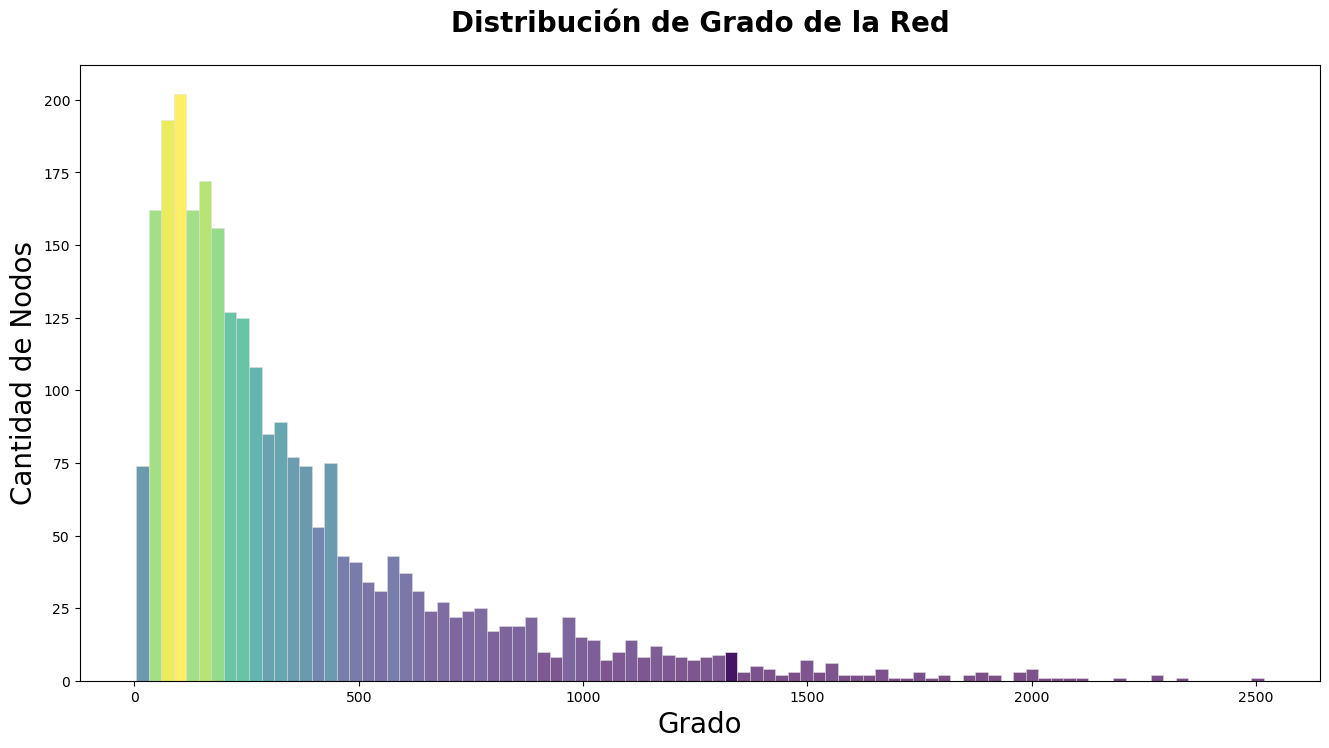

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

values = list(sorted_dict0.values())
n, bins, patches = plt.hist(values, bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
# Make one bin stand out   
patches[47].set_alpha(1) # Set opacity
# Add title and labels with custom font sizes
plt.title('Distribución de grado de la Red', fontsize=12)
plt.xlabel('Grado', fontsize=20)
plt.ylabel('Cantidad de Nodos', fontsize=20)
ax.set_title("Distribución de Grado de la Red",
             pad=24, fontweight=700, fontsize=20)
plt.show()

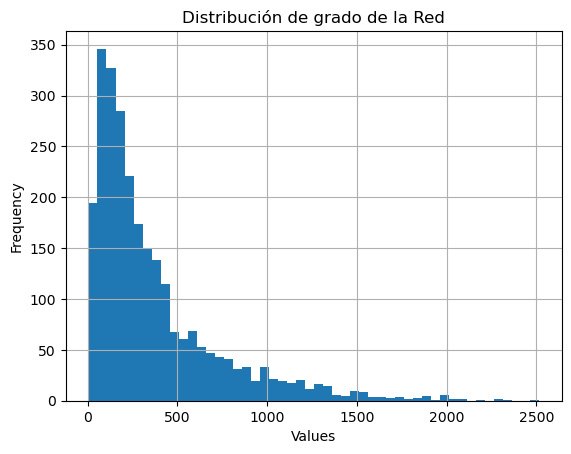

In [11]:
# Get the values from the dictionary
values = list(dict10.values())

# Create the histogram
plt.hist(values, bins=50)

# Set labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribución de grado de la Red')

# Add grid
plt.grid(True)

# Show the histogram
plt.show()


**Estadisticos de la red**

Número de nodos:  2638
Número de enlaces:  489674
-------
Grado promedio:  371.24639878695984
-------
Grado mínimo:  4
Grado máximo:  2517
-------
Densidad:  0.14078361728743263
Diametro:  3


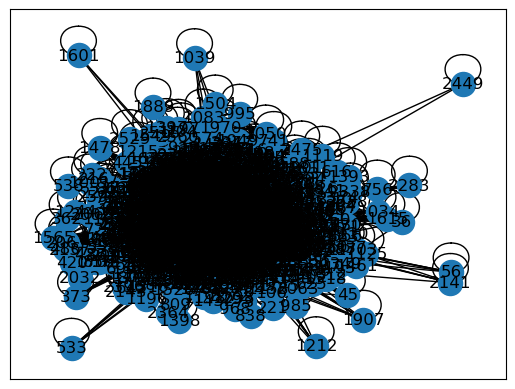

In [12]:
#F0.edges(data=True)
N10 = len(W)
L10 = W.size()
degrees10 = list(dict(W.degree()).values())
kmin10 = min(degrees10)
kmax10 = max(degrees10)
print("Número de nodos: ", N10)
print("Número de enlaces: ", L10)
print('-------')
print("Grado promedio: ", 2*L10/N10) 
print('-------')
print("Grado mínimo: ", kmin10)
print("Grado máximo: ", kmax10)
print('-------')
print('Densidad: ', nx.density(W))
print('Diametro: ',nx.diameter(W))

nx.draw_networkx(W)

**Distribución de grado en Logaritmo**

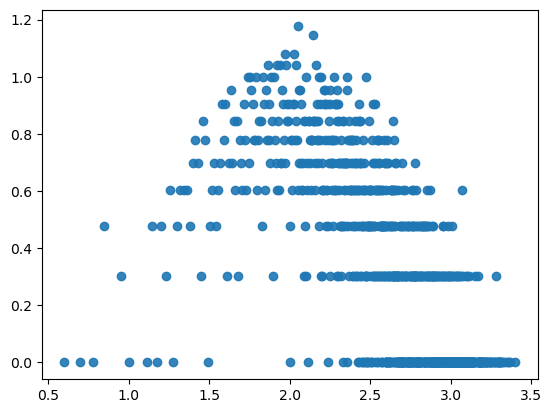

In [13]:
d = {}
for i, j in dict(nx.degree(W)).items():
    if j in d:
        d[j] += 1
    else:
        d[j] = 1
x = np.log10(list((d.keys())))
y = np.log10(list(d.values()))
plt.scatter(x, y, alpha=0.9)
plt.show()

### 5.2 Red Filtrada

100%|██████████████████████████████████████████████████████████████████████████████| 2638/2638 [10:29<00:00,  4.19it/s]


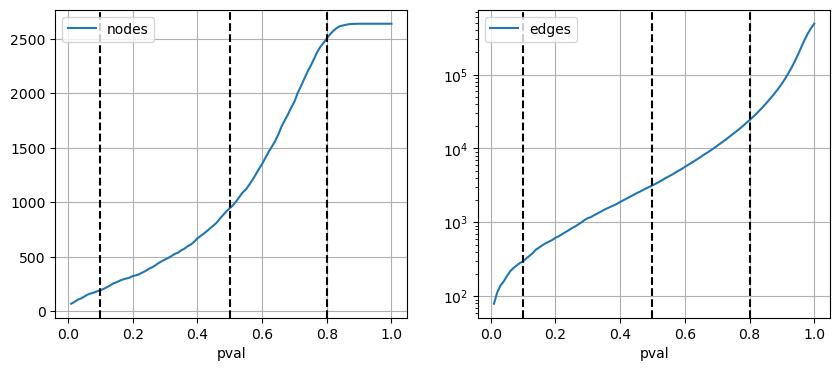

In [14]:


# Matriz de Co-Ocurrencia
od_matrix = list_cooc.set_index(['i', 'j']).unstack().fillna(0)
indices = od_matrix.index
columns = od_matrix.columns
od_matrix = od_matrix.values

# eliminamos la diagonal (decisión de análisis: no nos interesan los auto-enlaces)
od_matrix = od_matrix-np.diag(od_matrix.diagonal())


n = len(od_matrix)
phi = np.zeros((n,n)) #matrix to store the phi correlations
tval = np.zeros((n,n))
pval = np.zeros((n,n)) # Significancia
phi2 = np.zeros((n,n)) # Pesos finales
exit = np.zeros((n,n)) # Matriz con unos



M = od_matrix.sum(axis=1) # total number of obervations of each JUEGO (suma sobre las filas)
T = sum(M) # Total number of observations

pval_limit = 1 # significancia limite, 1 significa no filtrar
cnt_limit = 0 # minimo numero de coincidencias a considerar en la od_matrix, 0 significa no filtrar


# El mitico doble for
for i in tqdm(range(n)):# https://github.com/tqdm/tqdm  (barra de progreso)
    for j in range(n):
        p1 = T*od_matrix[i,j]-M[i]*M[j]
        p2 = np.sqrt(M[i]*M[j]*(T-M[i])*(T-M[j]))
        if p2 == 0:
            phi[i,j] = 0
        else:
            phi[i,j] = p1/p2
            
        if True: #phi[i,j] > 0:
            p1 = np.sqrt(max(M[i],M[j])-2)
            p2 = np.sqrt(1-phi[i,j]**2)
            tval[i,j] = phi[i,j]*p1/p2
            pval[i,j] = stats.t.sf(np.abs(tval[i,j]),max(M[i],M[j])-2)*2
            # Se evaluan los criterios para ver si la correlacion es significativa
            if pval[i,j] <= pval_limit and od_matrix[i,j] > cnt_limit:
                exit[i,j] = 1
                phi2[i,j] = phi[i,j]
            else:
                exit[i,j] = 0
                phi2[i,j] = 0

# Creamos un dataframe con toda la inforamcion estadistica de la red

df_edgelist_phi  = pd.DataFrame(phi, index=indices, columns=columns).stack().reset_index()
df_edgelist_phi.columns = ['source', 'target', 'phi']# esto es por convención, recuerden que es este grafo es no-dirigido
df_edgelist_phi = df_edgelist_phi[df_edgelist_phi['source']<=df_edgelist_phi['target']] # eliminamos duplicados

df_edgelist_pval = pd.DataFrame(pval, index=indices, columns=columns).stack().reset_index()
df_edgelist_pval.columns = ['source', 'target', 'pval']
df_edgelist_pval = df_edgelist_pval[df_edgelist_pval['source']<=df_edgelist_pval['target']] # eliminamos duplicados


# El DataFrame final contiene el valor phi, el pval y el número de veces que ocurre que dos IDs i y j están conectados
df = df_edgelist_phi.merge(df_edgelist_pval).merge(list_cooc.rename(columns={'i': 'source', 'j': 'target'}), how='left')
df['pairs'] = df['pairs'].fillna(0).astype(int) 
df = df[df['pairs']>0]

# Visualización del número de nodos y aristas según un filtro en pval
pvalues = np.arange(0.01,1.01,0.01)#Return evenly spaced values within a given interval.
total_nodes = []
total_edges = []
for p in pvalues:
    __df = df.pipe(lambda x : x[x['pval']<=p])
    n_nodes = pd.concat([__df['source'], __df['target']]).nunique()
    total_nodes.append(n_nodes)
    total_edges.append(len(__df))
pval_df = pd.DataFrame([pvalues, total_nodes, total_edges]).T
pval_df.columns = ['pval', 'nodes', 'edges']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
pval_df.plot('pval', 'nodes', ax=ax1)
pval_df.plot('pval', 'edges', ax=ax2)
for pval in [0.1, 0.5, 0.8]:
    ax1.axvline(pval, ls='--', color='k')
    ax2.axvline(pval, ls='--', color='k')

ax2.set_yscale('log')
ax1.grid()
ax2.grid()

In [15]:
# Filtros
pval_filt=0.1
df_viz=df[df['pval']<=pval_filt]
df_viz=df_viz[df_viz['source']!=df_viz['target']]
df_viz

,source,target,phi,pval,pairs
39520,15,70,0.012544,8.172956e-03,687
39922,15,472,0.006063,8.149482e-02,754
39992,15,542,0.010338,8.708109e-02,373
42416,16,344,0.013288,8.070244e-02,160
44081,16,2009,0.009607,5.177663e-02,401
...,...,...,...,...,...
3345257,2117,2514,0.011111,4.711518e-02,165
3404040,2246,2473,0.023578,9.739592e-07,909
3404081,2246,2514,0.012263,7.124371e-02,143
3466667,2470,2493,0.018204,8.668128e-02,108


In [16]:
# Creación de la red
G=nx.from_pandas_edgelist(df_viz, 'source', 'target')

# The network has disconnected components, let's check the size of each component in descending order
compon=[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
compon
print('Non connected: '+ str(sum(compon)-compon[0]))
print('Connected nodes en la compoenente gigante: '+ str(compon[0]) +' de '+str(G.number_of_nodes())+' nodos totales.')

print(compon)



# Let's extract and use only the giant component
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

Non connected: 23
Connected nodes en la compoenente gigante: 169 de 192 nodos totales.
[169, 5, 5, 5, 2, 2, 2, 2]


**Distribución de Grado de la Componente Gigante**

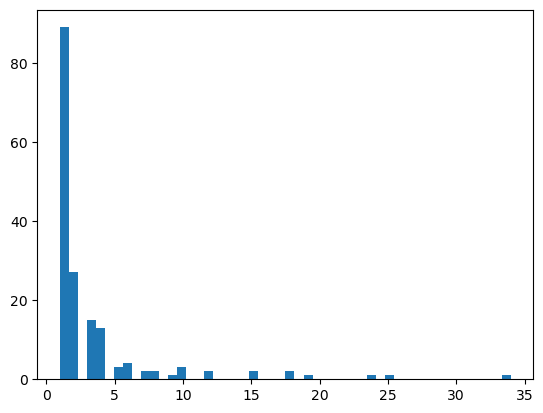

In [17]:
# Filtered
F = S[0]
dict1=dict(F.degree())  # node 0 has degree 1
sorted_dict = {}
sorted_keys = sorted(dict1, key=dict1.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_dict[w] = dict1[w]

#plt.hist((dict1.values()), bins=np.logspace(0,3))
#plt.loglog()
plt.hist((dict1.values()), bins=50)
plt.show()

**Estadisticos de la red**

Número de nodos:  169
Número de enlaces:  270
-------
Grado promedio:  3.195266272189349
-------
Grado mínimo:  1
Grado máximo:  34
-------
Densidad:  0.019019442096365174
Diametro:  10


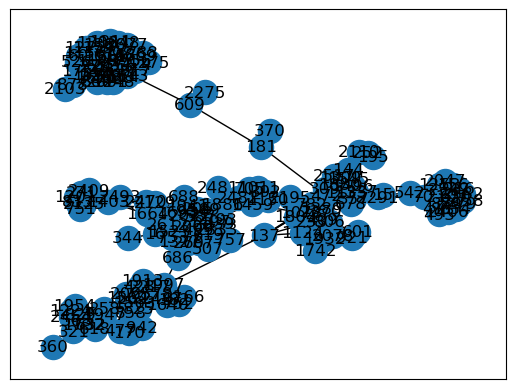

In [18]:
N10 = len(F)
L10 = F.size()
degrees10 = list(dict(F.degree()).values())
kmin10 = min(degrees10)
kmax10 = max(degrees10)
print("Número de nodos: ", N10)
print("Número de enlaces: ", L10)
print('-------')
print("Grado promedio: ", 2*L10/N10) 
print('-------')
print("Grado mínimo: ", kmin10)
print("Grado máximo: ", kmax10)
print('-------')
print('Densidad: ', nx.density(F))
print('Diametro: ',nx.diameter(F))

nx.draw_networkx(F)

**Distribución de grado en Logaritmo**

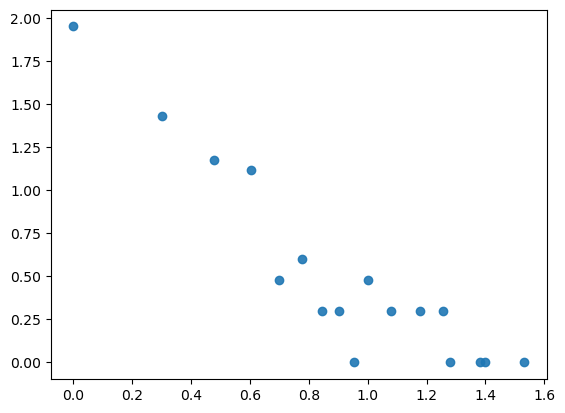

In [19]:
d = {}
for i, j in dict(nx.degree(F)).items():
    if j in d:
        d[j] += 1
    else:
        d[j] = 1
x = np.log10(list((d.keys())))
y = np.log10(list(d.values()))
plt.scatter(x, y, alpha=0.9)
plt.show()

#### Grado versus el Coeficiente de Clustering

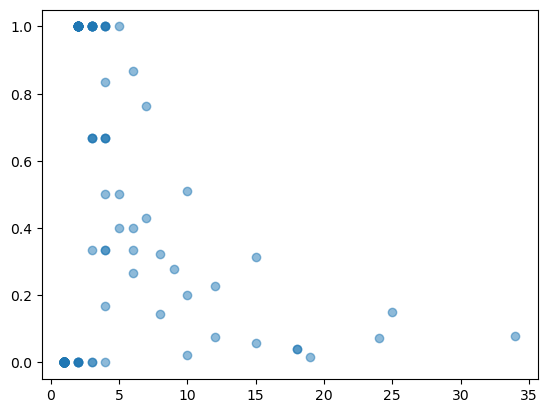

In [20]:
degree_g = dict(nx.degree(F))
clustering_g=dict(nx.clustering(F))

x = degree_g.values()
y = clustering_g.values()


# colors = np.random.rand(N)
# area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, alpha=0.5)
plt.show()

### 5.3 Detección de comunidades

In [21]:
import community.community_louvain as cl
from community import community_louvain
# compute the best partition
partition = community_louvain.best_partition(F, random_state=5)
A = F

partition_df = pd.DataFrame([partition]).T.reset_index()
partition_df.columns = ['id', 'partition']
partition_df.groupby('partition')['id'].count()
#partition

partition
0    18
1    31
2    25
3    11
4    39
5    32
6     4
7     9
Name: id, dtype: int64

Se detectan 8 comunidades


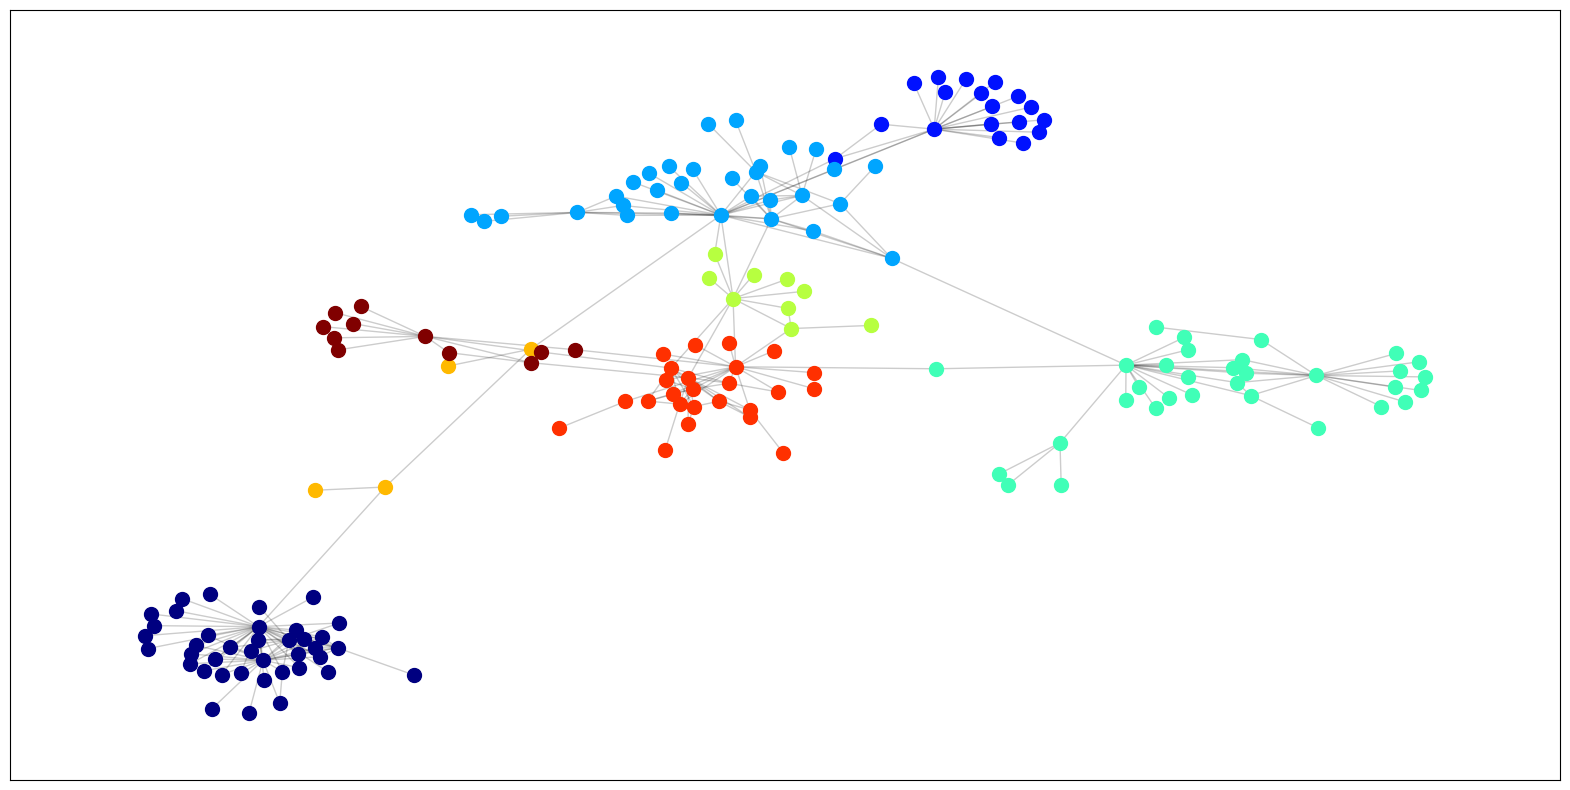

In [22]:
plt.figure(figsize=(20, 10))
#https://datoslab.cl/hes/

partition = community_louvain.best_partition(A)

size = (len(set(partition.values())))#Numero de comunidades
print('Se detectan %d comunidades' % (size))

pos = nx.spring_layout(A) # Layout para la red (coordenadas de los nodos y enlaces)

count = 0
colors = [np.array(cm.jet(x)).reshape(1,-1) for x in np.linspace(0, 1, size)]#cm.jet es el mapa de colores https://www.programcreek.com/python/example/56498/matplotlib.cm.jet
for com in set(partition.values()): #para cada comunidad
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]#guarda los personajes que pertenecen a la comunidad `com`
    nx.draw_networkx_nodes(A, pos, list_nodes, node_size = 100, node_color=colors[count])#plotea nodos con colors por comunidad
    count = count + 1# para iterar sobre los colores
nx.draw_networkx_edges(A, pos, alpha=0.2)#plotea enlaces
plt.show()

**Se incorpora la información de nombre, su categoría ,  la comunidad a la que pertenece, cantidad de reviews a la estructura de la red**

In [23]:
#se incorpora el registro de review, para luego hacer el merge con la comunidad
nodes = nodes.rename({'lugar':'placeId'},axis ='columns')
df7 = datos[['placeId','place name','Categoria query']].merge(nodes,on='placeId',how='left').drop_duplicates()

In [24]:
# Cantidad de lugares con comunidad
len(partition)

169

In [25]:
#se crea la columna 'comunidad', para identificar a qué comunidad pertenece cada lugar
df7['community'] = df7['id'].map(partition)
# Se cuenta el numero de comentarios por lugar
df5 = (pd.DataFrame(datos[['placeId','reviewId']]
                    .groupby('placeId')
                    .count())
       .reset_index().rename(columns={'reviewId':'review'}))
# Se cuenta el número de clientes por lugar
df6 = (pd.DataFrame(datos[['placeId','reviewerId']]
                    .groupby('placeId')
                    .count())
       .reset_index().rename(columns={'reviewerId':'n'}))
df7 = df7.merge(df5,on='placeId',how='outer')
df7 = df7.merge(df6,on='placeId',how='outer')

df7 = df7.dropna().reset_index()
df7

,index,placeId,place name,Categoria query,id,community,review,n
0,0,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,472,2.0,19896,19896
1,1,ChIJ41uz4JCNF5YRLwxxfJDZSLA,Teatro del Lago,performing arts theater,233,2.0,13211,13211
2,2,ChIJP0Zv4I-NF5YRD7XoH4aE-og,Muelle de Frutillar,island,1078,2.0,12020,12020
3,3,ChIJ4ZOKg1E6GJYRY63qPBuODTg,Plaza de Armas de Puerto Montt,tourist attraction,258,3.0,8733,8733
4,4,ChIJvb-MUWw2FpYRx8dXksZs5Gg,Plaza de Armas de Osorno,performing arts theater,2473,0.0,7787,7787
...,...,...,...,...,...,...,...,...
168,1310,ChIJH3K-S0IdIpYRV78MWbo5Ev4,Hostal Guarida del Trauco,casino,751,7.0,112,112
169,1379,ChIJK6-xypU2FpYRsEOL--LeMqA,Terminal Rahue,transportation service,878,0.0,96,96
170,1435,ChIJiaTq9p0AGJYRShPV8ST-IuY,Plaza De Trenes,national park,1947,3.0,87,87
171,1975,ChIJJ0o2RH_5IZYR9-t1f4xVc-4,Panadería LUNA,cafeteria,833,7.0,33,33


In [26]:
for i in range(len(df7['id'])):
    A.nodes[df7['id'].iloc[i]]['place name'] = df7['place name'].iloc[i]
    A.nodes[df7['id'].iloc[i]]['Categoria query'] = df7['Categoria query'].iloc[i]
    A.nodes[df7['id'].iloc[i]]['review'] = df7['review'].iloc[i]  
    

In [27]:
nx.write_gexf(A, "Resultados/wRed_Filtrada_Comunidad.gexf")

In [28]:
Q=community_louvain.modularity(partition,A)
print("La modularidad de esta componente de la red es:", Q)

La modularidad de esta componente de la red es: 0.7421673525377229


In [29]:
# Cantidad de lugares por comunidad
df7['community'].value_counts()

0.0    39
2.0    34
3.0    32
6.0    25
1.0    18
7.0    12
4.0     9
5.0     4
Name: community, dtype: int64

**Algunos lugares no cuentan con comunidad debido a que la base df7 se filtra previamente mediante el valor p de la correlación phi (inferencia). Por lo tanto, si hay un valor faltante en la comunidad, significa que no pertenece a la red ni a la componente principal, y por ende se elimina.**

In [30]:
df8 = df7[df7.community.notnull()].drop(['id','index','review'],axis=1)

**Cálculo de promedio de clientes por lugar, según la comunidad**

In [31]:
prom_ofertantes = df8.groupby('community').mean(n)
prom_ofertantes

,n
community,
0.0,1388.205128
1.0,2173.944444
2.0,3205.882353
3.0,2368.500000
4.0,1692.444444
5.0,3091.500000
6.0,2264.160000
7.0,779.750000
